## Scintillation detector data for unfolding

*Erik Hogenbirk, ehogenbi@nikhef.nl, May/June 2016 *

Introduction goes here

### Function definitions

In [4]:
%run function_definitions.ipynb

### Data location

In [5]:
cal_filenames_0 = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_8.MPA',
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_9.MPA',
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_10.MPA']
cal_labels_0 = [
    'Bi-207',
    'Na-22',
    'Cs-137']
bg_filenames_0 = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_12.mpa',
    './PTB_DATA/2016_JUN_02/2016_JUN_02_2_5MeV_NE213_FG_1.mpa']
ng_filenames_0 = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_7.mpa', # 50 kV 2.5 mA 0°
    './PTB_DATA/2016_JUN_01/2016_JUN_01_2_5MeV_NE213_FG_1.mpa', # 50 kV 2.5 mA 0°
    './PTB_DATA/2016_JUN_01/2016_JUN_01_2_5MeV_NE213_FG_2.mpa', # 40 kV 1.0 mA +140°
    ]

### Gamma calibration

Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


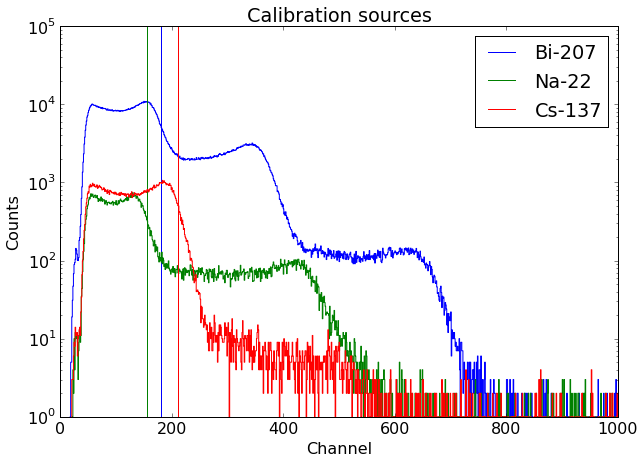

In [6]:
my_colors = ['blue', 'green', 'red']
for filename, label, color in zip(cal_filenames_0, cal_labels_0, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    plt.plot(spec,linestyle='steps', label=label, color=color)
    fwhm_pos = get_fwhm_pos(spec)
    plt.axvline(get_fwhm_pos(spec), color=color)
plt.yscale('log')
plt.title("Calibration sources")
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.xlim(0,1000)
plt.legend()
plt.show()

In [7]:
energy_list   = []
fwhm_pos_list = []

for filename, label, color in zip(cal_filenames_0, cal_labels_0, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    if label == 'Bi-207':
        # https://ehs.ucsd.edu/rad/radionuclide/Bi-207.pdf
        energy_list.append(get_compton_energy(570.))
        fwhm_pos_list.append(get_fwhm_pos(spec))
        energy_list.append(get_compton_energy(1064.))
        fwhm_pos_list.append(get_fwhm_pos(spec[300:500]) + 300)
        energy_list.append(get_compton_energy(1770.))
        fwhm_pos_list.append(get_fwhm_pos(spec[500:800]) + 500)
    if label == 'Na-22':
        energy_list.append(get_compton_energy(511.))
        fwhm_pos_list.append(get_fwhm_pos(spec))
        energy_list.append(get_compton_energy(1274.))
        fwhm_pos_list.append(get_fwhm_pos(spec[300:600]) + 300)
    
    if label == 'Cs-137':
        energy_list.append(get_compton_energy(662.))
        fwhm_pos_list.append(get_fwhm_pos(spec))


Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


In [8]:
from scipy.optimize import curve_fit
p_scale, _ = curve_fit(poly_1, energy_list, fwhm_pos_list)
print("Offset: %.2f channels, slope: %.3f channels/keV" % (p_scale[0], p_scale[1]))

# Invert relation
p_scale_to_e = [- p_scale[0] / p_scale[1], 1 / p_scale[1]]
e_scale = [poly_1(x, *p_scale_to_e) for x in range(4096)]


Offset: 12.60 channels, slope: 0.420 channels/keV


(0, 800)

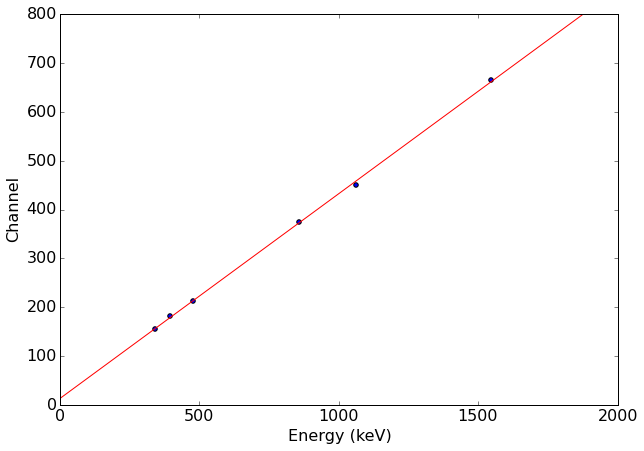

In [9]:
plt.scatter(energy_list, fwhm_pos_list)
plt.plot(range(2000), [poly_1(x, *p_scale) for x in range(2000)], color='red', label='Linear fit')
plt.xlabel('Energy (keV)')
plt.ylabel('Channel')
plt.xlim(0,2000)
plt.ylim(0,800)

### Load neutron and background data

In [10]:
# NG data
spec2d_list = []
for ng_filename in ng_filenames_0:
    line_n = find_line_start(ng_filename,'[CDAT2')
    spec2d_raw = get_spectrum(ng_filename, line_n)
    spec2d = np.reshape(spec2d_raw, (1024,4096))
    spec2d_list.append(spec2d)
spec2d = sum(spec2d_list)

Spectrum containing 4194304 samples read, total 976692 counts
Spectrum containing 4194304 samples read, total 1244420 counts
Spectrum containing 4194304 samples read, total 1867828 counts


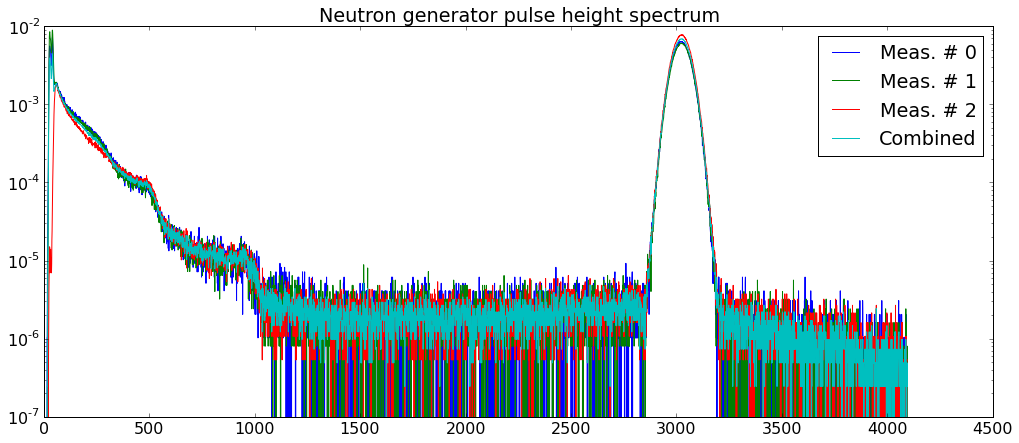

In [11]:
# Check that spectra coincide
scale_it = True # Toggle scaling by the total number of counts
plt.figure(figsize=(17,7))
for i, spec in enumerate(spec2d_list):
    if scale_it:
        norm_fac = 1./np.sum(spec)
    else:
        norm_fac = 1.
    plt.plot(norm_fac*np.sum(spec, axis=0), label='Meas. # %d' % i)
if scale_it:
    norm_fac = 1./np.sum(spec2d)
else:
    norm_fac = 1.
plt.plot(norm_fac*np.sum(spec2d, axis=0), label='Combined')
plt.yscale('log')
plt.legend()
plt.title('Neutron generator pulse height spectrum')
plt.show()

In [12]:
# BG data
spec2d_bg_list = []
for bg_filename in bg_filenames_0:
    line_n = find_line_start(bg_filename,'[CDAT2')
    spec2d_raw = get_spectrum(bg_filename, line_n)
    spec2d_bg = np.reshape(spec2d_raw, (1024,4096))
    spec2d_bg_list.append(spec2d_bg)
spec2d_bg = sum(spec2d_bg_list)

Spectrum containing 4194304 samples read, total 2968699 counts
Spectrum containing 4194304 samples read, total 3252444 counts


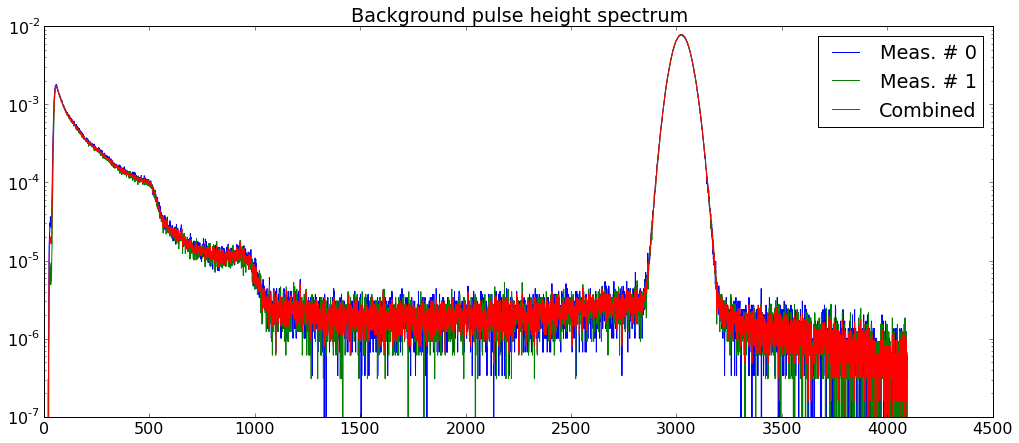

In [13]:
# Check that spectra coincide
scale_it = True # Toggle scaling by the total number of counts
plt.figure(figsize=(17,7))
for i, spec in enumerate(spec2d_bg_list):
    if scale_it:
        norm_fac = 1./np.sum(spec)
    else:
        norm_fac = 1.
    plt.plot(norm_fac*np.sum(spec, axis=0), label='Meas. # %d' % i)
if scale_it:
    norm_fac = 1./np.sum(spec2d_bg)
else:
    norm_fac = 1.
plt.plot(norm_fac*np.sum(spec2d_bg, axis=0), label='Combined')
plt.yscale('log')
plt.title('Background pulse height spectrum')
plt.legend()
plt.show()

### Cut class defintion

In [14]:
class Cut:
    '''
    Produce a cut function to cut on a percentile list.
    '''
    
    pct = 0.
    pct_list = [True for x in range(4096) ] 
    x_thr = 0.
    y_thr = 0.
    
    def get_percentile(self, spec2d, pct):
        self.pct_list = []
        self.pct = pct
        for x in range(len(spec2d[0])):
            self.pct_list.append(self.get_percentile_pos(spec2d[:,x],pct))
        
    def get_percentile_pos(self, dist, percent):
        tot = sum(dist)
        count = 0
        for i, x in enumerate(dist):
            if count >= tot*percent/100.:
                return i
            count += x
        print('WARNING! Error in get_percentile_pos')
        return -1
    
    def f_cut(self, x, y):
        '''
        FALSE = CUT
        TRUE = KEEP
        '''
        cut_y = self.pct_list[x-1]
        if y < cut_y:
            return False
        if x < self.x_thr:
            return False
        if y < self.y_thr:
            return False
        else:
            return True
        
    def plot_bounds(self, **kwargs):
        plt.plot(range(len(self.pct_list)), self.pct_list, **kwargs)
        plt.axvline(self.x_thr, **kwargs)
        plt.axhline(self.y_thr, **kwargs)
        
    def plot_percentile(self, **kwargs):
        plt.plot(range(len(self.pct_list)), self.pct_list, **kwargs)

### Calculate cuts

In [15]:
cut_list = []
for percentile in [99.0, 99.5]:
    cut = Cut()
    cut.get_percentile(spec2d_bg, percentile)
    cut_list.append(cut)

### Show cuts on background and foreground

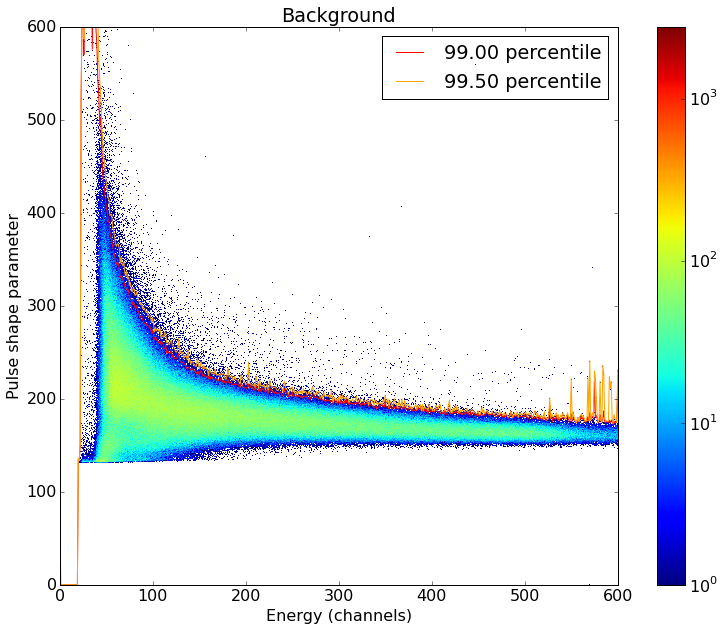

In [28]:
plt.figure(figsize=(14,10))
im = plt.imshow(spec2d_bg, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
    cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('Background')
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()

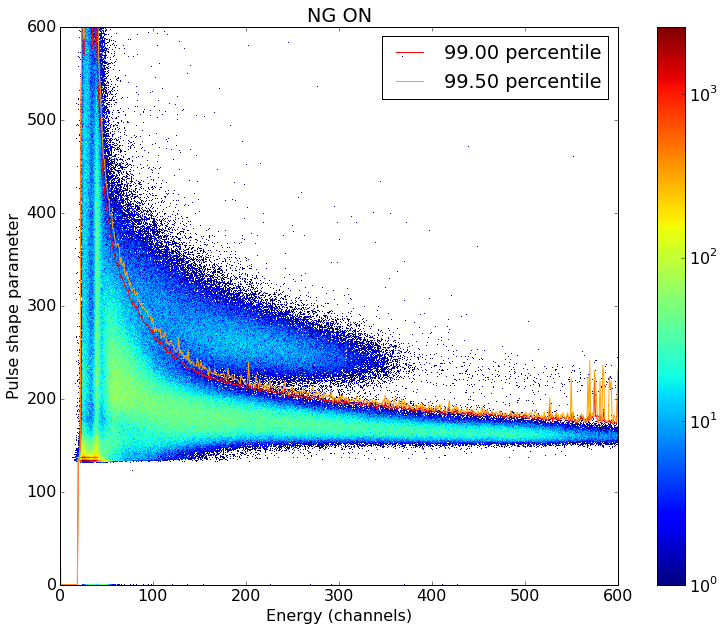

In [29]:
plt.figure(figsize=(14,10))
im = plt.imshow(spec2d, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
    cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('NG ON')
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()

### Apply cut

In [18]:
cut = cut_list[1]
cut.x_thr = 60.
spec2d_cut = cut_hist2d(spec2d,cut.f_cut)
spec2d_bg_cut = cut_hist2d(spec2d_bg,cut.f_cut)

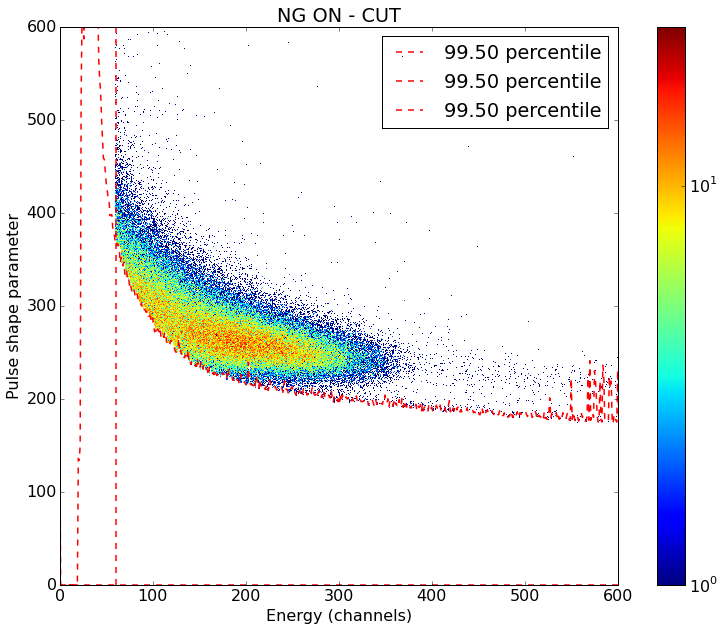

In [30]:
plt.figure(figsize=(14,10))
im = plt.imshow(spec2d_cut, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('NG ON - CUT')
cut.plot_bounds(color='red', ls='--', lw=1.5, label='%.2f percentile' % cut.pct)
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()

### Show pulse height spectra

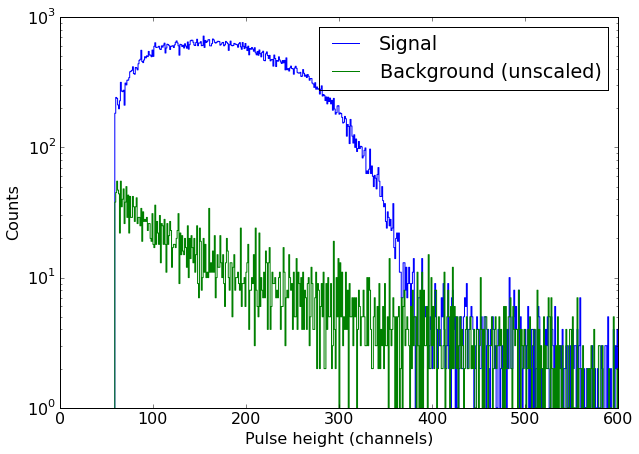

In [20]:
plt.plot(np.sum(spec2d_cut, axis=0), linestyle = 'steps', label='Signal')
plt.plot(np.sum(spec2d_bg_cut, axis=0), linestyle = 'steps', label='Background (unscaled)')
plt.xlim(0,600)
plt.yscale('log')
plt.xlabel('Pulse height (channels)')
plt.ylabel('Counts')
plt.legend()
plt.show()


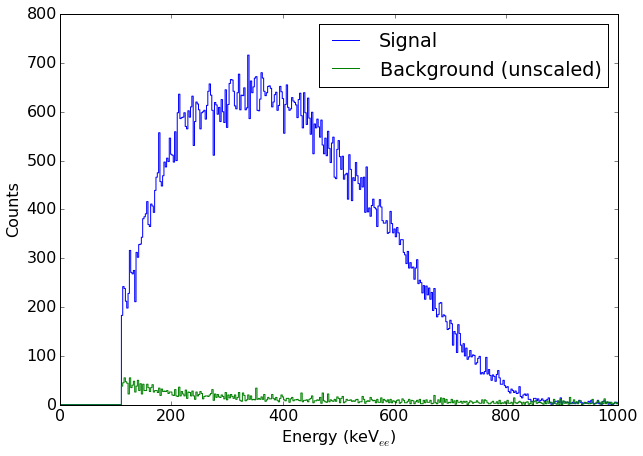

In [21]:
plt.plot(e_scale, np.sum(spec2d_cut, axis=0), linestyle = 'steps', label='Signal')
plt.plot(e_scale, np.sum(spec2d_bg_cut, axis=0), linestyle = 'steps', label='Background (unscaled)')
plt.xlim(0,1000)
#plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Counts')
plt.legend()
plt.show()


In [22]:
x1 = e_scale
f1 = np.sum(spec2d_cut, axis=0)
x2 = [e_scale[i] for i in np.arange(0, len(f1)-1, 2)]
f2 = [f1[i] + f1[i+1] for i in np.arange(0, len(f1)-1, 2)]
x3 = [e_scale[i] for i in np.arange(0, len(f1)-2, 3)]
f3 = [f1[i] + f1[i+1] + f1[i+2] for i in np.arange(0, len(f1)-2, 3)]
x4 = [e_scale[i] for i in np.arange(0, len(f1)-3, 4)]
f4 = [f1[i -1] + f1[i] + f1[i+1] + f1[i+2] for i in np.arange(1, len(f1)-2, 4)]

(0, 1000)

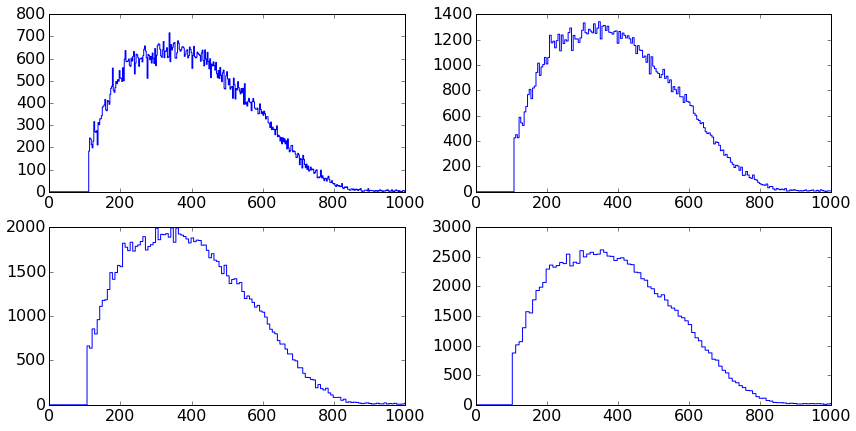

In [23]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(2,2,1)
plt.plot(x1, f1, linestyle='steps')
plt.xlim(0,1000)
fig.add_subplot(2,2,2)
plt.plot(x2, f2, linestyle='steps')
plt.xlim(0,1000)
fig.add_subplot(2,2,3)
plt.plot(x3, f3, linestyle='steps')
plt.xlim(0,1000)
fig.add_subplot(2,2,4)
plt.plot(x4, f4, linestyle='steps')
plt.xlim(0,1000)

In [ ]:
len(f)

In [ ]:
# plt.figure(figsize=(14,10))
# # im = plt.imshow(bla, origin='low', interpolation='none', # interpolation='nearest'
# #                 norm=LogNorm())
# # plt.colorbar()
# plt.xlim(0,150)
# plt.ylim(0,150)
# plt.contour(bla,[10, 20, 40], colors='red', linestyles = ('solid','--','solid'))

# plt.show()